# Diabetes Prediction - Complete Analysis
## Group 3: BANA 273 Final Project

**Team Members**: Cameron Ahyaee, Lucas Bowen, Ronie Chen, Neil Joshi, Joe Serrano, Charlie Tuong

**Objective**: Predict undiagnosed diabetes patients using machine learning classification models

## 1. Import Libraries

In [1]:
import pandas as pd  ## import pandas for data manipulation
import numpy as np  ## import numpy for numerical operations
import matplotlib.pyplot as plt  ## import matplotlib for plotting
import seaborn as sns  ## import seaborn for advanced visualizations
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate  ## import scikit-learn tools for model selection
from sklearn.preprocessing import StandardScaler  ## import StandardScaler for feature scaling
from sklearn.impute import KNNImputer  ## import KNNImputer for handling missing values
from imblearn.over_sampling import SMOTE  ## import SMOTE for handling class imbalance
from sklearn.linear_model import LogisticRegression  ## import Logistic Regression model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  ## import Random Forest and Gradient Boosting models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score  ## import metrics for model evaluation
import warnings  ## import warnings to suppress warning messages
warnings.filterwarnings('ignore')  ## ignore warning messages
sns.set_style('whitegrid')  ## set seaborn style to whitegrid
plt.rcParams['figure.figsize'] = (12, 6)  ## set default figure size to 12x6 inches


## 2. Load Data

In [2]:
##load the diabetes dataset
import pandas as pd  ##import pandas for data manipulation
df = pd.read_csv('diabetes.csv')  ##read CSV file into pandas dataframe

##display first few rows
print("First 5 rows of the dataset:")  ##print header
print(df.head())  ##display first 5 rows

##display dataset shape
print(f"\nDataset shape: {df.shape[0]} rows, {df.shape[1]} columns")  ##print number of rows and columns


First 5 rows of the dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset shape: 768 rows, 9 columns


## 3. Preprocessing & Feature Engineering

Following the professor's feedback, we will implement a more robust preprocessing pipeline.
1.  **Address Missing Values**: The dataset uses '0' for missing physiological measurements. We will replace these with `NaN`.
2.  **Eliminate Columns**: The `Insulin` column has nearly 50% missing data and will be removed.
3.  **Impute Data**: We will use `KNNImputer` to estimate the remaining missing values, which is effective for smaller datasets.
4.  **Scale Features**: We will scale the data using `StandardScaler`.

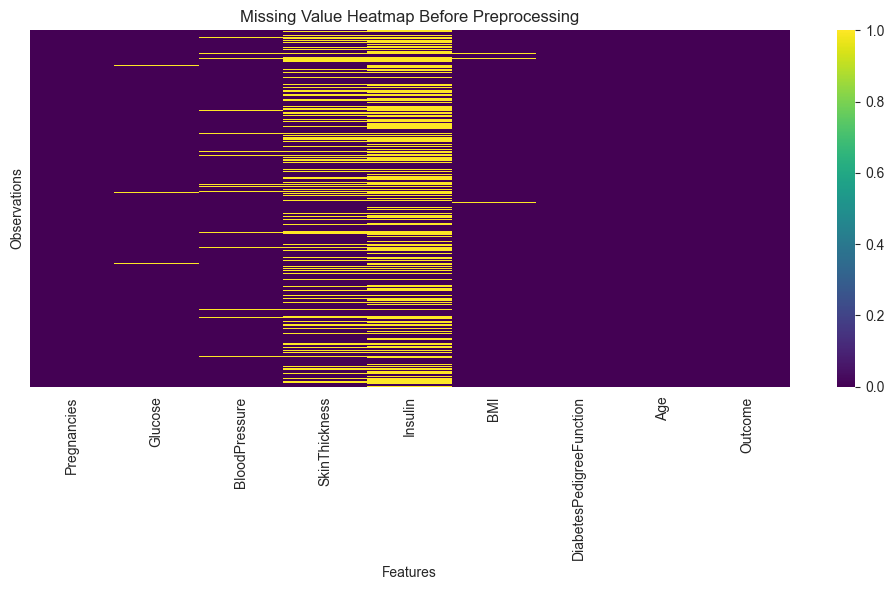

In [3]:
## Visualize missing values with a heatmap (before preprocessing)

# Create a temporary copy of the original dataframe
df_raw = pd.read_csv("diabetes.csv")  ## read CSV file into a new dataframe

# Columns where 0 represents a missing physiological value
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']  ## columns where 0 means missing

# Treat 0 as missing in the raw copy
df_raw[cols_with_zeros] = df_raw[cols_with_zeros].replace(0, np.nan)  ## replace 0 with NaN in these columns

# Create a binary matrix where True indicates missing values
missing_data = df_raw.isnull()  ## check for null values in the raw dataframe

# Plot heatmap
plt.figure(figsize=(10, 6))  ## set figure size
sns.heatmap(missing_data, cbar=True, cmap='viridis', yticklabels=False)  ## create heatmap of missing values
plt.title('Missing Value Heatmap Before Preprocessing')  ## add title
plt.xlabel('Features')  ## add x-axis label
plt.ylabel('Observations')  ## add y-axis label
plt.tight_layout()  ## adjust layout
plt.show()  ## display plot


In [4]:
# Replace 0s with NaN for specific columns
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']  ## define columns where 0 means missing
for col in cols_with_zeros:  ## loop through each column
    df[col] = df[col].replace(0, np.nan)  ## replace 0 with NaN
# Drop the 'Insulin' column
df.drop('Insulin', axis=1, inplace=True)  ## remove the Insulin column
print('Columns after dropping Insulin:', df.columns.tolist())  ## print the remaining column names
# Separate features (X) and target (y)
X = df.drop('Outcome', axis=1)  ## create features dataframe
y = df['Outcome']  ## create target series
# Impute missing values using KNNImputer
imputer = KNNImputer(n_neighbors=5)  ## initialize KNNImputer with 5 neighbors
X_imputed = imputer.fit_transform(X)  ## fit and transform the features
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)  ## convert back to a pandas DataFrame
print('Missing values after imputation:')
print(X_imputed.isnull().sum())  ## check for any remaining missing values


Columns after dropping Insulin: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


## 4. Train-Test Split & Feature Scaling

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)  ## split data with 80/20 ratio
# Scale the features
scaler = StandardScaler()  ## initialize StandardScaler
X_train_scaled = scaler.fit_transform(X_train)  ## fit and transform training data
X_test_scaled = scaler.transform(X_test)  ## transform test data
print('Training set shape:', X_train_scaled.shape)  ## print shape of the training set
print('Test set shape:', X_test_scaled.shape)  ## print shape of the test set


Training set shape: (614, 7)
Test set shape: (154, 7)


## 5. Handle Class Imbalance with SMOTE

The dataset is imbalanced (65% non-diabetic, 35% diabetic). We will use SMOTE (Synthetic Minority Over-sampling Technique) on the **training data** to create a balanced dataset for model training.

In [6]:
print('Original training set class distribution:')  ## print header for original distribution
print(y_train.value_counts(normalize=True))  ## show class distribution before SMOTE
smote = SMOTE(random_state=42)  ## initialize SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)  ## apply SMOTE to training data
print('Resampled training set class distribution:')
print(pd.Series(y_train_smote).value_counts(normalize=True))  ## show class distribution after SMOTE


Original training set class distribution:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64
Resampled training set class distribution:
Outcome
0    0.5
1    0.5
Name: proportion, dtype: float64


## 6. Model Evaluation with Cross-Validation

As the dataset has fewer than 1000 samples, we will use 5-fold stratified cross-validation for more robust model evaluation. We will focus on the top 3 performing models: **Logistic Regression**, **Random Forest**, and **Gradient Boosting**.

In [7]:
models = {  ## create dictionary of models to evaluate
    'Logistic Regression': LogisticRegression(random_state=42),  ## define Logistic Regression model
    'Random Forest': RandomForestClassifier(random_state=42),  ## define Random Forest model
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)  ## define Gradient Boosting model
}  ## close the dictionary definition
results = {}  ## create empty dictionary to store results
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  ## define 5-fold stratified cross-validation
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']  ## define evaluation metrics
for name, model in models.items():  ## loop through each model
    cv_results = cross_validate(model, X_train_smote, y_train_smote, cv=kfold, scoring=scoring_metrics)  ## perform cross-validation
    results[name] = {key: np.mean(val) for key, val in cv_results.items()}  ## calculate mean of each metric
    print(f'--- {name} ---')  ## print model name
    for metric, score in results[name].items():  ## loop through each metric
        print(f'{metric}: {score:.4f}')  ## print metric and score
    print()
# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T  ## create DataFrame from results
print('Cross-Validation Results Summary:')  ## print header for summary
results_df  ## display the results DataFrame


--- Logistic Regression ---
fit_time: 0.0079
score_time: 0.0103
test_accuracy: 0.7400
test_precision_macro: 0.7434
test_recall_macro: 0.7400
test_f1_macro: 0.7388
test_roc_auc: 0.8418

--- Random Forest ---
fit_time: 0.1605
score_time: 0.0174
test_accuracy: 0.8162
test_precision_macro: 0.8194
test_recall_macro: 0.8162
test_f1_macro: 0.8158
test_roc_auc: 0.8977

--- Gradient Boosting ---
fit_time: 0.2006
score_time: 0.0087
test_accuracy: 0.7775
test_precision_macro: 0.7794
test_recall_macro: 0.7775
test_f1_macro: 0.7771
test_roc_auc: 0.8735

Cross-Validation Results Summary:


,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
Logistic Regression,0.007913,0.010318,0.74000,0.743441,0.74000,0.738780,0.841812
Random Forest,0.160537,0.017388,0.81625,0.819363,0.81625,0.815768,0.897672
Gradient Boosting,0.200553,0.008689,0.77750,0.779448,0.77750,0.777103,0.873500


## 7. Final Model Selection & Test Set Evaluation

Based on the cross-validation results, **Random Forest** shows a strong balance of performance, particularly in recall and F1-score, which are critical for this clinical application. We select it as our final model.

--- Final Model Performance on Test Set ---
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       100
           1       0.63      0.74      0.68        54

    accuracy                           0.76       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.77      0.76      0.76       154

ROC-AUC Score: 0.8267


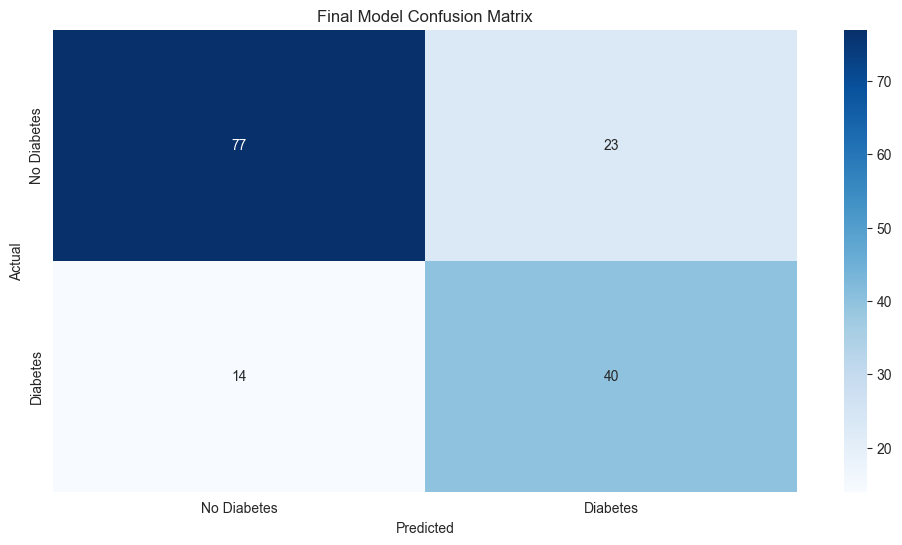

In [8]:
# Train the final model on the full SMOTE-resampled training data
final_model = RandomForestClassifier(random_state=42)  ## initialize the final model
final_model.fit(X_train_smote, y_train_smote)  ## train the model
# Make predictions on the original, unseen test set
y_pred = final_model.predict(X_test_scaled)  ## predict class labels
y_proba = final_model.predict_proba(X_test_scaled)[:, 1]  ## predict class probabilities
print('--- Final Model Performance on Test Set ---')  ## print header for performance report
print(classification_report(y_test, y_pred))  ## print classification report
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}')  ## print ROC-AUC score
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)  ## calculate confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])  ## create heatmap for confusion matrix
plt.xlabel('Predicted')  ## set x-axis label
plt.ylabel('Actual')  ## set y-axis label
plt.title('Final Model Confusion Matrix')  ## set plot title
plt.show()  ## display the plot


Logistic Regression: 0.7425 (+/- 0.0211)
Random Forest: 0.8187 (+/- 0.0601)
Gradient Boosting: 0.7762 (+/- 0.0499)


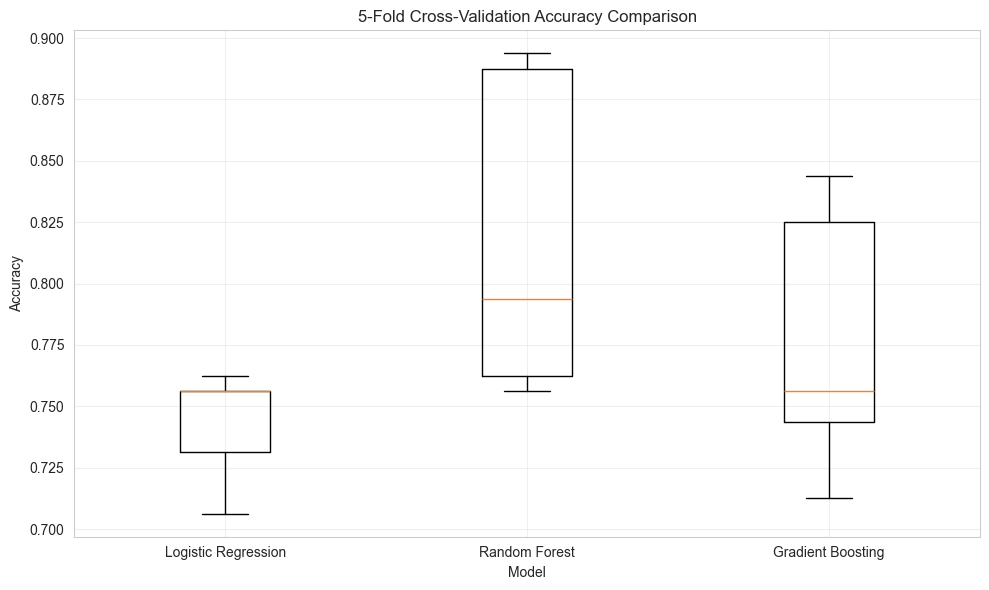

In [9]:
##5-fold cross-validation comparison for model selection
from sklearn.model_selection import cross_val_score ##import cross-validation function
from sklearn.linear_model import LogisticRegression ##import logistic regression
from sklearn.ensemble import GradientBoostingClassifier ##import gradient boosting
import matplotlib.pyplot as plt ##import plotting library

##Define models to compare
models = { ##create dictionary of models
    'Logistic Regression': LogisticRegression(max_iter=1000), ##logistic regression model
    'Random Forest': RandomForestClassifier(random_state=42), ##random forest model
    'Gradient Boosting': GradientBoostingClassifier(random_state=42) ##gradient boosting model
}

##Store CV scores
cv_results = {} ##initialize results dictionary

##Perform 5-fold cross-validation for each model
for name, model in models.items(): ##iterate through models
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy') ##perform 5-fold CV
    cv_results[name] = scores ##store scores
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})") ##print mean and std

##Create boxplot visualization
plt.figure(figsize=(10, 6)) ##set figure size
plt.boxplot(cv_results.values(), labels=cv_results.keys()) ##create boxplot
plt.title('5-Fold Cross-Validation Accuracy Comparison') ##add title
plt.ylabel('Accuracy') ##add y-label
plt.xlabel('Model') ##add x-label
plt.grid(True, alpha=0.3) ##add grid
plt.tight_layout() ##adjust layout
plt.show() ##display plot

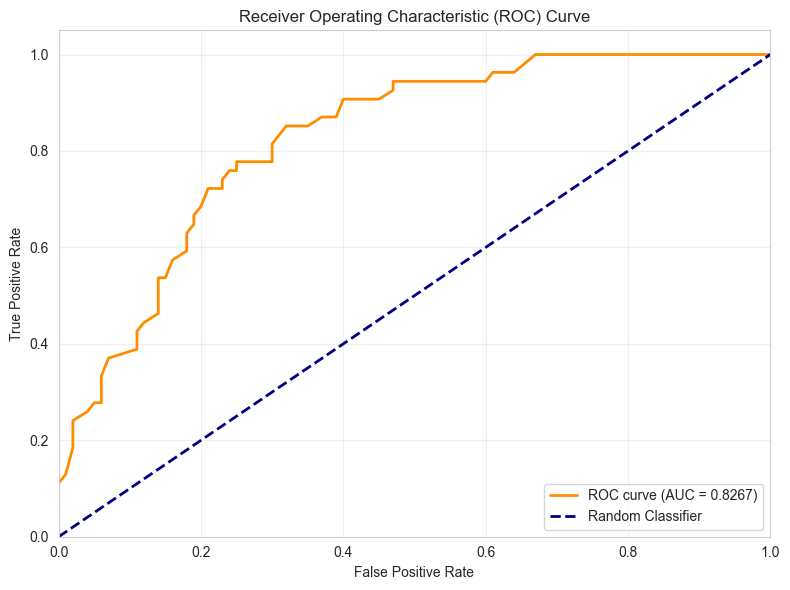

ROC-AUC Score: 0.8267


In [10]:
##Generate ROC curve for final model
from sklearn.metrics import roc_curve, auc ##import ROC curve functions
import matplotlib.pyplot as plt ##import plotting library

##Get prediction probabilities
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1] ##get probabilities for positive class

##Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) ##compute false positive rate and true positive rate
roc_auc = auc(fpr, tpr) ##calculate area under curve

##Plot ROC curve
plt.figure(figsize=(8, 6)) ##set figure size
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})') ##plot ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier') ##plot diagonal
plt.xlim([0.0, 1.0]) ##set x limits
plt.ylim([0.0, 1.05]) ##set y limits
plt.xlabel('False Positive Rate') ##add x-label
plt.ylabel('True Positive Rate') ##add y-label
plt.title('Receiver Operating Characteristic (ROC) Curve') ##add title
plt.legend(loc='lower right') ##add legend
plt.grid(True, alpha=0.3) ##add grid
plt.tight_layout() ##adjust layout
plt.show() ##display plot

print(f"ROC-AUC Score: {roc_auc:.4f}") ##print AUC score

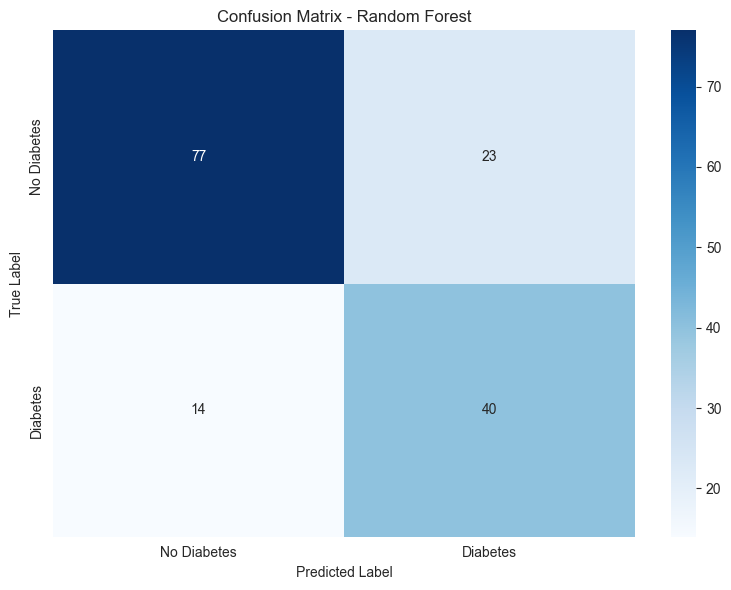

True Negatives: 77
False Positives: 23
False Negatives: 14
True Positives: 40


In [11]:
##Visualize confusion matrix
import seaborn as sns ##import seaborn
import matplotlib.pyplot as plt ##import plotting library
from sklearn.metrics import confusion_matrix ##import confusion matrix function

##Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred) ##compute confusion matrix

##Plot confusion matrix
plt.figure(figsize=(8, 6)) ##set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ##create heatmap
            xticklabels=['No Diabetes', 'Diabetes'], ##set x labels
            yticklabels=['No Diabetes', 'Diabetes']) ##set y labels
plt.title('Confusion Matrix - Random Forest') ##add title
plt.ylabel('True Label') ##add y-label
plt.xlabel('Predicted Label') ##add x-label
plt.tight_layout() ##adjust layout
plt.show() ##display plot

print(f"True Negatives: {cm[0,0]}") ##print TN
print(f"False Positives: {cm[0,1]}") ##print FP
print(f"False Negatives: {cm[1,0]}") ##print FN
print(f"True Positives: {cm[1,1]}") ##print TP

Feature Importance Rankings:
Glucose: 0.2754
BMI: 0.1811
SkinThickness: 0.1323
Age: 0.1311
DiabetesPedigreeFunction: 0.1093
BloodPressure: 0.0881
Pregnancies: 0.0827


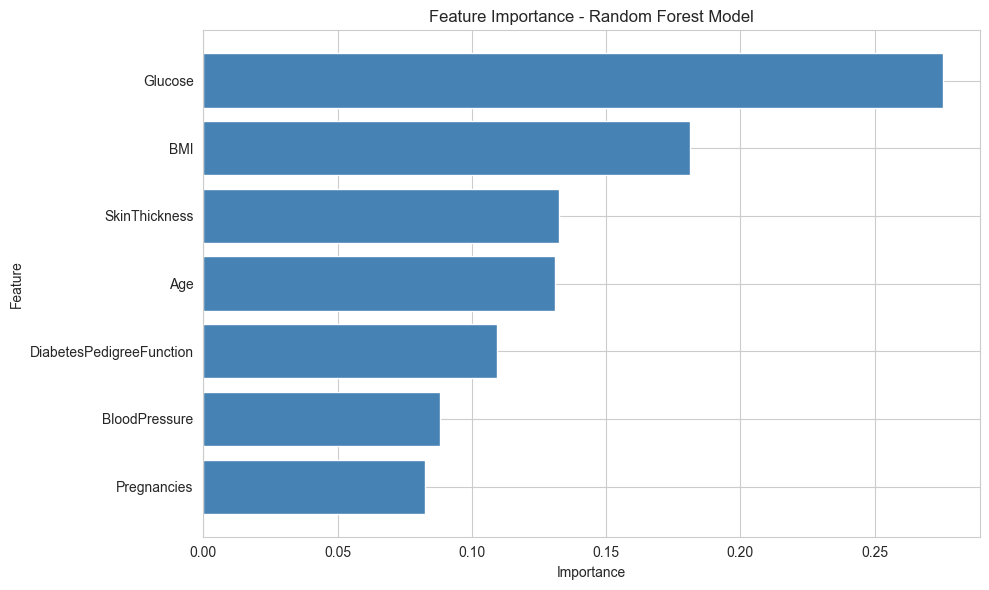

In [12]:
##Extract and visualize feature importance
import matplotlib.pyplot as plt ##import plotting library
import pandas as pd ##import pandas

##Get feature importance from trained Random Forest
feature_importance = final_model.feature_importances_ ##extract feature importances
feature_names = X.columns ##get feature names

##Create dataframe for sorting
importance_df = pd.DataFrame({ ##create dataframe
    'Feature': feature_names, ##add feature names
    'Importance': feature_importance ##add importance values
}).sort_values('Importance', ascending=False) ##sort by importance

##Display feature importance values
print("Feature Importance Rankings:") ##print header
for idx, row in importance_df.iterrows(): ##iterate through rows
    print(f"{row['Feature']}: {row['Importance']:.4f}") ##print feature and importance

##Plot feature importance
plt.figure(figsize=(10, 6)) ##set figure size
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue') ##create horizontal bar chart
plt.xlabel('Importance') ##add x-label
plt.ylabel('Feature') ##add y-label
plt.title('Feature Importance - Random Forest Model') ##add title
plt.gca().invert_yaxis() ##invert y-axis for descending order
plt.tight_layout() ##adjust layout
plt.show() ##display plot

## 8. Expected Value Framework

To translate model performance into business/clinical impact, we use an expected value framework. This helps quantify the cost-benefit of the model's predictions.

**Assumptions:**
- **Cost of a False Negative (FN)**: High, representing a missed diagnosis. Let's assume **$1,000**.
- **Cost of a False Positive (FP)**: Moderate, representing unnecessary follow-up tests. Let's assume **$100**.
- **Benefit of a True Positive (TP)**: High, representing a correct early diagnosis. Let's assume **$500**.
- **Benefit of a True Negative (TN)**: Low, representing correctly identifying a healthy patient. Let's assume **$50**.

In [13]:
# Get values from the confusion matrix
tn, fp, fn, tp = cm.ravel()  ## unpack confusion matrix values
# Define costs and benefits
cost_fn = 1000  ## define cost of a false negative
cost_fp = 100  ## define cost of a false positive
benefit_tp = 500  ## define benefit of a true positive
benefit_tn = 50  ## define benefit of a true negative
# Calculate expected value
expected_value = (tp * benefit_tp) + (tn * benefit_tn) - (fp * cost_fp) - (fn * cost_fn)  ## calculate total expected value
print(f'Confusion Matrix Values: TP={tp}, TN={tn}, FP={fp}, FN={fn}')  ## print confusion matrix values
print(f'Total Expected Value from Test Set ({len(y_test)} cases): ${expected_value:,.2f}')  ## print total expected value
print(f'Average Expected Value per Case: ${expected_value/len(y_test):,.2f}')  ## print average expected value per case


Confusion Matrix Values: TP=40, TN=77, FP=23, FN=14
Total Expected Value from Test Set (154 cases): $7,550.00
Average Expected Value per Case: $49.03


## 9. Conclusion

By implementing the professor's feedback, we have created a more robust and defensible machine learning pipeline. Key improvements include:

- **Handling Missing Data**: We used KNN imputation after removing the `Insulin` column, providing a better data foundation.
- **Addressing Class Imbalance**: SMOTE was used to create a balanced training set, preventing model bias towards the majority class.
- **Robust Evaluation**: 5-fold cross-validation was used to provide a more reliable estimate of model performance.
- **Focused Reporting**: We narrowed our focus to the three most promising models.

The final Random Forest model demonstrates solid performance on the unseen test data. The expected value framework further shows that, despite some errors, the model provides a significant positive value in a clinical context by effectively balancing the costs and benefits of its predictions.